In [2]:
# ===============================
# Step 1: Imports & Setup
# ===============================
import sys
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
sys.path.append(r"D:\I3D\pytorch-i3d")

from pytorch_i3d import InceptionI3d

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [23]:
class I3DDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        self.files, self.labels = [], []
        for cls_name, idx in self.class_to_idx.items():
            cls_dir = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_dir): continue
            for f in os.listdir(cls_dir):
                if f.endswith('.pt'):
                    self.files.append(os.path.join(cls_dir, f))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        data = torch.load(file_path).float()  # Ensure float

        # Normalize shape to (C, T, H, W)
        if data.dim() == 5:  # (N, C, T, H, W)
            data = data[0]
        if data.dim() == 4:  # (T, C, H, W)
            if data.shape[1] in (1,3) and data.shape[0] > 4:
                data = data.permute(1,0,2,3)
        elif data.dim() == 3 and data.shape[0] in (1,3):
            data = data.unsqueeze(1)
        else:
            raise ValueError(f"Unexpected tensor shape {data.shape} in {file_path}")

        # Normalize to [-1,1]
        data = data / 255.0
        mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1,1)
        std  = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1,1)
        data = (data - mean) / std

        if self.transform:
            data = self.transform(data)

        label = self.labels[idx]
        return data, torch.tensor(label, dtype=torch.long)

In [24]:
train_dir = r"D:\I3D\TRAINDATA"
test_dir  = r"D:\I3D\TESTDATA"

train_dataset = I3DDataset(train_dir)
test_dataset  = I3DDataset(test_dir)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("Classes:", train_dataset.class_to_idx)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

# ===============================

Classes: {'person': 0, 'snatcher': 1, 'victim': 2}
Train samples: 1013
Test samples: 127


In [ ]:
pretrained_path = r"D:\I3D\PRETRAINED\finetuned_aug_i3d_final (1).pt"

# Initialize the model first
num_classes = len(train_dataset.classes)
i3d = InceptionI3d(num_classes=num_classes, in_channels=3)

# Load pretrained/fine-tuned weights
# map_location ensures it works for CPU or CUDA
state_dict = torch.load(pretrained_path, map_location=device)
i3d.load_state_dict(state_dict)

# Send model to device
i3d = i3d.to(device)

# Redefine criterion and optimizer for fine-tuning
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(i3d.parameters(), lr=1e-5)  # Lower LR for fine-tuning

print("Loaded pretrained/fine-tuned model and ready for training.")



num_classes = len(train_dataset.classes)
i3d = InceptionI3d(num_classes=num_classes, in_channels=3)
i3d.replace_logits(num_classes)
i3d = i3d.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(i3d.parameters(), lr=1e-5)  # Lower LR
num_epochs = 20
patience = 5

# ===============================
# Step 5: Training Loop
# ===============================
best_val_loss = float('inf')
trigger_times = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    i3d.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_idx, (clips, labels) in enumerate(train_loader):
        clips, labels = clips.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = i3d(clips)
        outputs = outputs.view(outputs.size(0), -1)

        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(i3d.parameters(), max_norm=5)
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Real-time batch loss
        sys.stdout.write(f"\rEpoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        sys.stdout.flush()

    # ================================
    # Validation
    # ================================
    i3d.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for clips, labels in test_loader:
            clips, labels = clips.to(device), labels.to(device).long()
            outputs = i3d(clips)
            outputs = outputs.view(outputs.size(0), -1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_acc = correct / total
    avg_val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # ================================
    # Print epoch summary
    # ================================
    sys.stdout.write(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:\n")
    sys.stdout.write(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc*100:.2f}%\n")
    sys.stdout.write(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc*100:.2f}%\n")
    sys.stdout.flush()

    # ================================
    # Early stopping
    # ================================
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(i3d.state_dict(), 'best_i3d_model.pth')
        sys.stdout.write("Saved best model.\n")
        sys.stdout.flush()
    else:
        trigger_times += 1
        sys.stdout.write(f"EarlyStopping counter: {trigger_times} out of {patience}\n")
        sys.stdout.flush()
        if trigger_times >= patience:
            sys.stdout.write("Early stopping triggered.\n")
            sys.stdout.flush()
            break

EOFError: Ran out of input

In [17]:
import sys

num_epochs=20
learning_rate = 1e-4
patience = 5  # Early stopping patience
best_val_loss = float('inf')
trigger_times = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(i3d.parameters(), lr=learning_rate)

# ================================
# Lists to store metrics for plotting
# ================================
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# ================================
# Training Loop with Early Stopping & real-time printing
# ================================
for epoch in range(num_epochs):
    i3d.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch_idx, (clips, labels) in enumerate(train_loader):
        clips, labels = clips.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = i3d(clips)                   # [B, C, 1, 1, 1]
        outputs = outputs.view(outputs.size(0), -1)  # [B, C]

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Calculate batch accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Real-time batch loss print
        sys.stdout.write(f"\rEpoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        sys.stdout.flush()

    # ================================
    # Validation Step using test_loader
    # ================================
    i3d.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for clips, labels in test_loader:
            clips, labels = clips.to(device), labels.to(device).long()
            outputs = i3d(clips)
            outputs = outputs.view(outputs.size(0), -1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # ================================
    # Calculate epoch metrics
    # ================================
    avg_train_loss = epoch_loss / len(train_loader)
    train_acc = correct / total
    avg_val_loss = val_loss / len(test_loader)
    val_acc = val_correct / val_total

    # Save metrics for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print summary for this epoch
    sys.stdout.write(f"\nEpoch [{epoch+1}/{num_epochs}] Summary:\n")
    sys.stdout.write(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%\n")
    sys.stdout.write(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%\n")
    sys.stdout.flush()

    # ================================
    # Early Stopping
    # ================================
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(i3d.state_dict(), 'best_i3d_model.pth')  # save best model
        sys.stdout.write("Saved best model.\n")
        sys.stdout.flush()
    else:
        trigger_times += 1
        sys.stdout.write(f"EarlyStopping counter: {trigger_times} out of {patience}\n")
        sys.stdout.flush()
        if trigger_times >= patience:
            sys.stdout.write("Early stopping triggered. Training stopped.\n")
            sys.stdout.flush()
            break


Epoch [1/20], Batch [254/254], Loss: 1.0228
Epoch [1/20] Summary:
Train Loss: 1.1139, Train Accuracy: 38.80%
Val Loss: 1.0897, Val Accuracy: 39.37%
Saved best model.
Epoch [2/20], Batch [254/254], Loss: 1.2496
Epoch [2/20] Summary:
Train Loss: 1.0977, Train Accuracy: 40.77%
Val Loss: 1.1857, Val Accuracy: 39.37%
EarlyStopping counter: 1 out of 5
Epoch [3/20], Batch [254/254], Loss: 1.0821
Epoch [3/20] Summary:
Train Loss: 1.0819, Train Accuracy: 42.35%
Val Loss: 1.0949, Val Accuracy: 34.65%
EarlyStopping counter: 2 out of 5
Epoch [4/20], Batch [254/254], Loss: 1.1474
Epoch [4/20] Summary:
Train Loss: 1.0844, Train Accuracy: 43.53%
Val Loss: 6.2514, Val Accuracy: 39.37%
EarlyStopping counter: 3 out of 5
Epoch [5/20], Batch [254/254], Loss: 0.9051
Epoch [5/20] Summary:
Train Loss: 1.0829, Train Accuracy: 41.46%
Val Loss: 4.4321, Val Accuracy: 39.37%
EarlyStopping counter: 4 out of 5
Epoch [6/20], Batch [254/254], Loss: 1.3980
Epoch [6/20] Summary:
Train Loss: 1.0830, Train Accuracy: 43.1

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for clips, labels in test_loader:
        clips, labels = clips.to(device), labels.to(device)
        outputs = i3d(clips).view(clips.size(0), -1)
        _, preds = torch.max(outputs.data, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [19]:
accuracy = np.mean(all_preds == all_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")


Test Accuracy: 39.37%


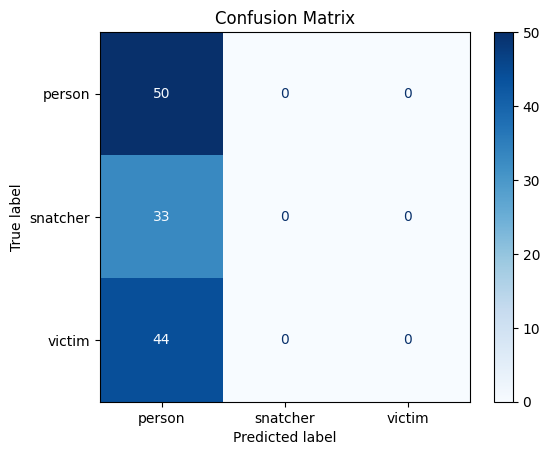

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [21]:
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print(report)


              precision    recall  f1-score   support

      person       0.39      1.00      0.56        50
    snatcher       0.00      0.00      0.00        33
      victim       0.00      0.00      0.00        44

    accuracy                           0.39       127
   macro avg       0.13      0.33      0.19       127
weighted avg       0.16      0.39      0.22       127



d:\I3D\env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\I3D\env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\I3D\env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


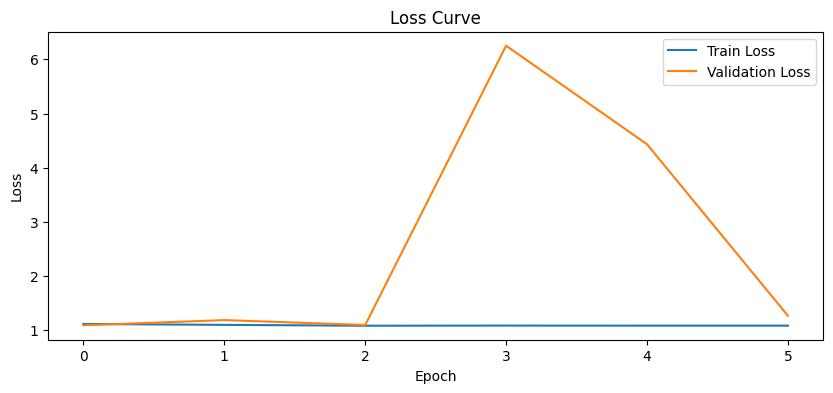

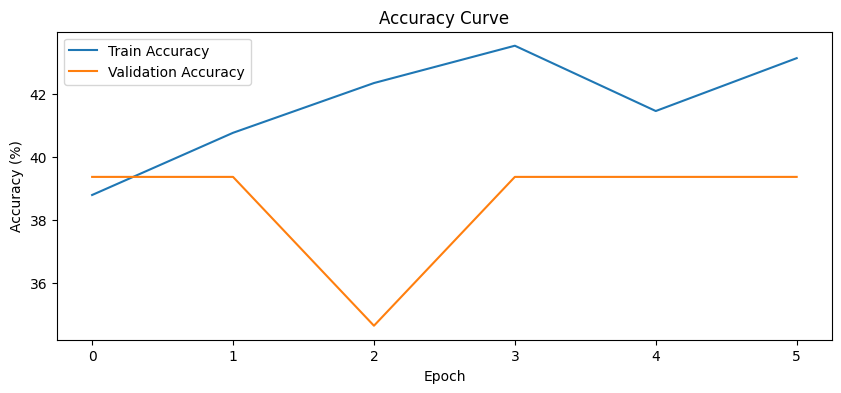

In [22]:
import matplotlib.pyplot as plt

# Loss Curve
plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# Accuracy Curve
plt.figure(figsize=(10,4))
plt.plot([x*100 for x in train_accuracies], label="Train Accuracy")
plt.plot([x*100 for x in val_accuracies], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.show()


In [1]:
import os, random, time
from glob import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
)
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys # Imported for sys.stdout.write()

# Use StepLR for stabilizing convergence
from torch.optim.lr_scheduler import StepLR 

MAX_EPOCHS = 50 # Unified max epochs

# === 2. Dataset (MODIFIED for 3 classes) ===
class PtClipDataset(Dataset):
    CLASS_MAP = {
        "snatcher": 0,     # Index 0
        "victim": 1,       # Index 1
        "person": 2        # Index 2 (Normal/Bystander)
    }
    
    def __init__(self, root, split="TRAINDATA"): 
        self.samples = []
        
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path):
            sys.stdout.write(f"Error: Split directory not found at {split_path}\n")
            return

        for folder_name, class_index in self.CLASS_MAP.items():
            folder = os.path.join(split_path, folder_name)
            if not os.path.isdir(folder):
                sys.stdout.write(f"Warning: Class folder not found at {folder}\n")
                continue
            
            for f in glob(os.path.join(folder, "*.pt")):
                self.samples.append((f, class_index))
        
        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        clip = torch.load(path, map_location='cpu').float()
        return clip, label
    
    def get_labels(self):
        return [label for _, label in self.samples]

# === 3. Load pretrained I3D (FIX: Freeze Layers) ===
num_classes = 3 
model = torch.hub.load("facebookresearch/pytorchvideo", "i3d_r50", pretrained=True)

# 🔥 FIX: Freeze all layers except the last two blocks (5 and 6)
# This prevents overfitting by limiting the changes to high-level features
for name, param in model.named_parameters():
    # Only allow gradients for the classification layers or the last two stages
    if name.startswith('blocks.5') or name.startswith('blocks.6'):
        param.requires_grad = True
    else:
        param.requires_grad = False

# ✅ Replace last layer to output 3 classes
model.blocks[6].proj = nn.Linear(model.blocks[6].proj.in_features, num_classes)

# Set device and move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# === 4. Training setup (IMBALANCE, LR, BATCH_SIZE FIXES) ===
# ----------------------------------------------------------------------
data_root = "D:\I3D" 
classes = ["Snatcher", "Victim", "Person"] 
train_ds = PtClipDataset(data_root, split="TRAINDATA")
val_ds = PtClipDataset(data_root, split="TESTDATA")

sys.stdout.write(f"Loaded {len(train_ds)} training samples and {len(val_ds)} validation samples.\n")
if len(train_ds) == 0:
    raise ValueError("Training dataset is empty. Check your D:\\I3D\\TRAINDATA path and file extensions (.pt).")

# --- IMBALANCE HANDLING: CALCULATE WEIGHTED LOSS ---
train_labels = train_ds.get_labels()
class_counts = np.bincount(train_labels, minlength=num_classes)
total_samples = len(train_labels)
class_weights = total_samples / class_counts
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

sys.stdout.write(f"Class Counts (0, 1, 2): {class_counts}\n")
sys.stdout.write(f"Loss Weights (0, 1, 2): {class_weights_tensor.cpu().numpy().round(2)}\n")
# --------------------------------------------------------------------

BATCH_SIZE = 2 # 🔥 FIX: Reduced from 4 to 2 for better stability and VRAM usage

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# 🔥 FIX: Reduced initial LR from 1e-3 to 1e-4 for slower, more stable training
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 

scheduler = StepLR(optimizer, step_size=10, gamma=0.1) 

scaler = GradScaler()
patience = 10
best_val_f1 = 0.0
no_improve_epochs = 0  

Using cache found in C:\Users\Avijit/.cache\torch\hub\facebookresearch_pytorchvideo_main


Loaded 914 training samples and 226 validation samples.
Class Counts (0, 1, 2): [256 253 405]
Loss Weights (0, 1, 2): [3.57 3.61 2.26]


In [2]:
for epoch in range(1, MAX_EPOCHS + 1): 
    epoch_start = time.time()
    
    # --- Print statements converted to sys.stdout.write() and flush() ---
    sys.stdout.write(f"\nEpoch {epoch}/{MAX_EPOCHS}\n")
    sys.stdout.flush()

    # --- Train ---
    model.train()
    train_losses, train_preds, train_targs = [], [], []
    for clips, labels in tqdm(train_loader, desc="Training"):
        clips, labels = clips.to(device), labels.to(device) 
        optimizer.zero_grad()
        with autocast():
            outputs = model(clips)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_losses.append(loss.item())
        train_preds += outputs.argmax(dim=1).cpu().tolist()
        train_targs += labels.cpu().tolist()

    # Apply scheduler step after training epoch
    scheduler.step()
    
    # Train metrics
    train_acc = accuracy_score(train_targs, train_preds)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        train_targs, train_preds, average="weighted", zero_division=0
    )

    # --- Validation ---
    model.eval()
    val_losses, val_preds, val_targs, val_probs = [], [], [], []
    with torch.no_grad():
        for clips, labels in tqdm(val_loader, desc="Validation"):
            clips, labels = clips.to(device), labels.to(device) 
            outputs = model(clips)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            probs = torch.softmax(outputs, dim=1)
            val_probs += probs.cpu().tolist()
            val_preds += outputs.argmax(dim=1).cpu().tolist()
            val_targs += labels.cpu().tolist()

    # Val metrics
    val_acc = accuracy_score(val_targs, val_preds)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        val_targs, val_preds, average="weighted", zero_division=0
    )

    # Log epoch results
    elapsed = time.time() - epoch_start
    
    # --- Print statements converted to sys.stdout.write() and flush() ---
    sys.stdout.write(f"Time: {elapsed:.1f}s\n")
    sys.stdout.write(f" Train Loss: {np.mean(train_losses):.4f} | Acc: {train_acc:.4f} | "
                     f"P: {train_prec:.4f} R: {train_rec:.4f} F1: {train_f1:.4f}\n")
    sys.stdout.write(f" Val   Loss: {np.mean(val_losses):.4f} | Acc: {val_acc:.4f} | "
                     f"P: {val_prec:.4f} R: {val_rec:.4f} F1: {val_f1:.4f}\n")
    
    # --- Save checkpoints ---
    torch.save(model.state_dict(), "last.pt") 
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        no_improve_epochs = 0
        torch.save(model.state_dict(), "aug_data_i3d.pt")
        sys.stdout.write(f" 🔥 Saved new best model with F1={best_val_f1:.4f}\n")
    else:
        no_improve_epochs += 1
        sys.stdout.write(f" Patience counter: {no_improve_epochs}/{patience}\n")
        
    # Early stopping
    if no_improve_epochs >= patience:
        sys.stdout.write("⏹ Early stopping triggered.\n")
        
    # Flush all output written during this epoch
    sys.stdout.flush()
    
    if no_improve_epochs >= patience:
        break


Epoch 1/50


Training:   0%|          | 0/457 [00:00<?, ?it/s]

Validation: 100%|██████████| 113/113 [00:32<00:00,  3.43it/s]


Time: 139.3s
 Train Loss: 0.9937 | Acc: 0.5284 | P: 0.5059 R: 0.5284 F1: 0.5105
 Val   Loss: 0.9436 | Acc: 0.5796 | P: 0.6310 R: 0.5796 F1: 0.5524
 🔥 Saved new best model with F1=0.5524

Epoch 2/50


Validation: 100%|██████████| 113/113 [00:21<00:00,  5.24it/s]

Time: 85.8s
 Train Loss: 0.8426 | Acc: 0.6269 | P: 0.6252 R: 0.6269 F1: 0.6174
 Val   Loss: 0.9762 | Acc: 0.5531 | P: 0.6425 R: 0.5531 F1: 0.5500
 Patience counter: 1/10

Epoch 3/50



Validation: 100%|██████████| 113/113 [00:22<00:00,  5.07it/s]


Time: 89.5s
 Train Loss: 0.7003 | Acc: 0.7221 | P: 0.7251 R: 0.7221 F1: 0.7185
 Val   Loss: 0.7424 | Acc: 0.7080 | P: 0.7246 R: 0.7080 F1: 0.6994
 🔥 Saved new best model with F1=0.6994

Epoch 4/50


Validation: 100%|██████████| 113/113 [00:21<00:00,  5.23it/s]


Time: 88.9s
 Train Loss: 0.5488 | Acc: 0.7856 | P: 0.7860 R: 0.7856 F1: 0.7836
 Val   Loss: 0.7816 | Acc: 0.7080 | P: 0.7503 R: 0.7080 F1: 0.7007
 🔥 Saved new best model with F1=0.7007

Epoch 5/50


Validation: 100%|██████████| 113/113 [00:21<00:00,  5.30it/s]

Time: 106.0s
 Train Loss: 0.4335 | Acc: 0.8446 | P: 0.8495 R: 0.8446 F1: 0.8442
 Val   Loss: 0.8964 | Acc: 0.6372 | P: 0.7639 R: 0.6372 F1: 0.6396
 Patience counter: 1/10

Epoch 6/50



Validation: 100%|██████████| 113/113 [00:21<00:00,  5.17it/s]

Time: 88.4s
 Train Loss: 0.3455 | Acc: 0.8742 | P: 0.8759 R: 0.8742 F1: 0.8735
 Val   Loss: 0.8483 | Acc: 0.6814 | P: 0.7249 R: 0.6814 F1: 0.6805
 Patience counter: 2/10

Epoch 7/50



Validation: 100%|██████████| 113/113 [00:21<00:00,  5.27it/s]


Time: 89.0s
 Train Loss: 0.3147 | Acc: 0.8906 | P: 0.8937 R: 0.8906 F1: 0.8903
 Val   Loss: 0.7454 | Acc: 0.7832 | P: 0.7918 R: 0.7832 F1: 0.7824
 🔥 Saved new best model with F1=0.7824

Epoch 8/50


Validation: 100%|██████████| 113/113 [00:24<00:00,  4.61it/s]


Time: 106.5s
 Train Loss: 0.2528 | Acc: 0.9070 | P: 0.9091 R: 0.9070 F1: 0.9068
 Val   Loss: 0.6613 | Acc: 0.7788 | P: 0.7799 R: 0.7788 F1: 0.7773
 Patience counter: 1/10

Epoch 9/50


Validation: 100%|██████████| 113/113 [00:21<00:00,  5.19it/s]

Time: 89.1s
 Train Loss: 0.1799 | Acc: 0.9289 | P: 0.9296 R: 0.9289 F1: 0.9289
 Val   Loss: 0.8450 | Acc: 0.7566 | P: 0.7897 R: 0.7566 F1: 0.7513
 Patience counter: 2/10

Epoch 10/50



Validation: 100%|██████████| 113/113 [00:21<00:00,  5.17it/s]

Time: 91.1s
 Train Loss: 0.2008 | Acc: 0.9223 | P: 0.9229 R: 0.9223 F1: 0.9224
 Val   Loss: 0.6610 | Acc: 0.7743 | P: 0.8077 R: 0.7743 F1: 0.7789
 Patience counter: 3/10

Epoch 11/50



Validation: 100%|██████████| 113/113 [00:22<00:00,  5.13it/s]


Time: 92.4s
 Train Loss: 0.1157 | Acc: 0.9661 | P: 0.9664 R: 0.9661 F1: 0.9661
 Val   Loss: 0.5932 | Acc: 0.8319 | P: 0.8469 R: 0.8319 F1: 0.8307
 🔥 Saved new best model with F1=0.8307

Epoch 12/50


Validation: 100%|██████████| 113/113 [00:22<00:00,  5.04it/s]

Time: 88.0s
 Train Loss: 0.0911 | Acc: 0.9781 | P: 0.9784 R: 0.9781 F1: 0.9781
 Val   Loss: 0.6662 | Acc: 0.8009 | P: 0.8317 R: 0.8009 F1: 0.7985
 Patience counter: 1/10

Epoch 13/50



Validation: 100%|██████████| 113/113 [00:22<00:00,  5.10it/s]

Time: 91.0s
 Train Loss: 0.0612 | Acc: 0.9891 | P: 0.9892 R: 0.9891 F1: 0.9891
 Val   Loss: 0.6052 | Acc: 0.8230 | P: 0.8473 R: 0.8230 F1: 0.8204
 Patience counter: 2/10

Epoch 14/50



Validation: 100%|██████████| 113/113 [00:22<00:00,  5.05it/s]


Time: 93.8s
 Train Loss: 0.0595 | Acc: 0.9858 | P: 0.9859 R: 0.9858 F1: 0.9858
 Val   Loss: 0.6226 | Acc: 0.8451 | P: 0.8501 R: 0.8451 F1: 0.8446
 🔥 Saved new best model with F1=0.8446

Epoch 15/50


Validation: 100%|██████████| 113/113 [00:21<00:00,  5.32it/s]


Time: 87.5s
 Train Loss: 0.0670 | Acc: 0.9836 | P: 0.9838 R: 0.9836 F1: 0.9836
 Val   Loss: 0.5536 | Acc: 0.8540 | P: 0.8552 R: 0.8540 F1: 0.8541
 🔥 Saved new best model with F1=0.8541

Epoch 16/50


Validation: 100%|██████████| 113/113 [00:21<00:00,  5.15it/s]


Time: 92.3s
 Train Loss: 0.0450 | Acc: 0.9912 | P: 0.9914 R: 0.9912 F1: 0.9913
 Val   Loss: 0.5864 | Acc: 0.8363 | P: 0.8504 R: 0.8363 F1: 0.8358
 Patience counter: 1/10

Epoch 17/50


Validation: 100%|██████████| 113/113 [00:31<00:00,  3.63it/s]


Time: 97.8s
 Train Loss: 0.0534 | Acc: 0.9858 | P: 0.9859 R: 0.9858 F1: 0.9858
 Val   Loss: 0.5698 | Acc: 0.8363 | P: 0.8477 R: 0.8363 F1: 0.8351
 Patience counter: 2/10

Epoch 18/50


Validation: 100%|██████████| 113/113 [00:27<00:00,  4.09it/s]


Time: 116.3s
 Train Loss: 0.0608 | Acc: 0.9836 | P: 0.9837 R: 0.9836 F1: 0.9836
 Val   Loss: 0.5934 | Acc: 0.8363 | P: 0.8389 R: 0.8363 F1: 0.8352
 Patience counter: 3/10

Epoch 19/50


Validation: 100%|██████████| 113/113 [00:26<00:00,  4.22it/s]


Time: 116.2s
 Train Loss: 0.0420 | Acc: 0.9902 | P: 0.9902 R: 0.9902 F1: 0.9901
 Val   Loss: 0.7146 | Acc: 0.7743 | P: 0.8073 R: 0.7743 F1: 0.7667
 Patience counter: 4/10

Epoch 20/50


Validation: 100%|██████████| 113/113 [00:21<00:00,  5.34it/s]

Time: 93.3s
 Train Loss: 0.0528 | Acc: 0.9858 | P: 0.9858 R: 0.9858 F1: 0.9858
 Val   Loss: 0.6143 | Acc: 0.8142 | P: 0.8193 R: 0.8142 F1: 0.8131
 Patience counter: 5/10

Epoch 21/50



Validation: 100%|██████████| 113/113 [00:22<00:00,  5.13it/s]

Time: 87.6s
 Train Loss: 0.0433 | Acc: 0.9869 | P: 0.9869 R: 0.9869 F1: 0.9869
 Val   Loss: 0.6400 | Acc: 0.8274 | P: 0.8399 R: 0.8274 F1: 0.8259
 Patience counter: 6/10

Epoch 22/50



Validation: 100%|██████████| 113/113 [00:21<00:00,  5.15it/s]

Time: 88.4s
 Train Loss: 0.0425 | Acc: 0.9869 | P: 0.9869 R: 0.9869 F1: 0.9869
 Val   Loss: 0.5977 | Acc: 0.8186 | P: 0.8366 R: 0.8186 F1: 0.8162
 Patience counter: 7/10



Epoch 23/50


Validation: 100%|██████████| 113/113 [00:21<00:00,  5.22it/s]


Time: 90.0s
 Train Loss: 0.0437 | Acc: 0.9880 | P: 0.9880 R: 0.9880 F1: 0.9880
 Val   Loss: 0.6728 | Acc: 0.8274 | P: 0.8278 R: 0.8274 F1: 0.8270
 Patience counter: 8/10

Epoch 24/50


Validation: 100%|██████████| 113/113 [00:22<00:00,  4.98it/s]

Time: 92.6s
 Train Loss: 0.0396 | Acc: 0.9945 | P: 0.9946 R: 0.9945 F1: 0.9945
 Val   Loss: 0.6549 | Acc: 0.8186 | P: 0.8358 R: 0.8186 F1: 0.8159
 Patience counter: 9/10

Epoch 25/50



Validation: 100%|██████████| 113/113 [00:20<00:00,  5.43it/s]


Time: 89.6s
 Train Loss: 0.0378 | Acc: 0.9891 | P: 0.9891 R: 0.9891 F1: 0.9891
 Val   Loss: 0.6518 | Acc: 0.8363 | P: 0.8522 R: 0.8363 F1: 0.8356
 Patience counter: 10/10
⏹ Early stopping triggered.


Loading base I3D model architecture...


Using cache found in C:\Users\Avijit/.cache\torch\hub\facebookresearch_pytorchvideo_main


Successfully loaded model and weights.
Starting evaluation on 226 validation samples...


Evaluation: 100%|██████████| 113/113 [00:21<00:00,  5.16it/s]



=== FINAL MODEL PERFORMANCE ANALYSIS ===
Total Evaluation Time: 21.92s
Total Samples: 226

--- AGGREGATE METRICS ---
Overall Accuracy:   0.8540
Macro Avg Precision: 0.8530 | Recall: 0.8500 | F1: 0.8510
Weighted Avg P:      0.8552 | Recall: 0.8540 | F1: 0.8541
Micro-Avg ROC AUC:   0.9490
Weighted-Avg ROC AUC: 0.9457

--- Classification Report (Per-Class Metrics) ---
              precision    recall  f1-score   support

    Snatcher       0.81      0.84      0.82        61
      Victim       0.89      0.83      0.86        71
      Person       0.86      0.88      0.87        94

    accuracy                           0.85       226
   macro avg       0.85      0.85      0.85       226
weighted avg       0.86      0.85      0.85       226


--- Confusion Matrix Data ---
[[51  4  6]
 [ 4 59  8]
 [ 8  3 83]]


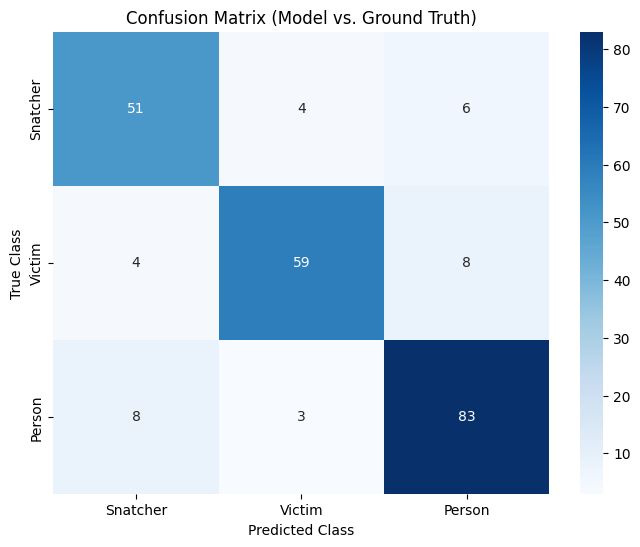

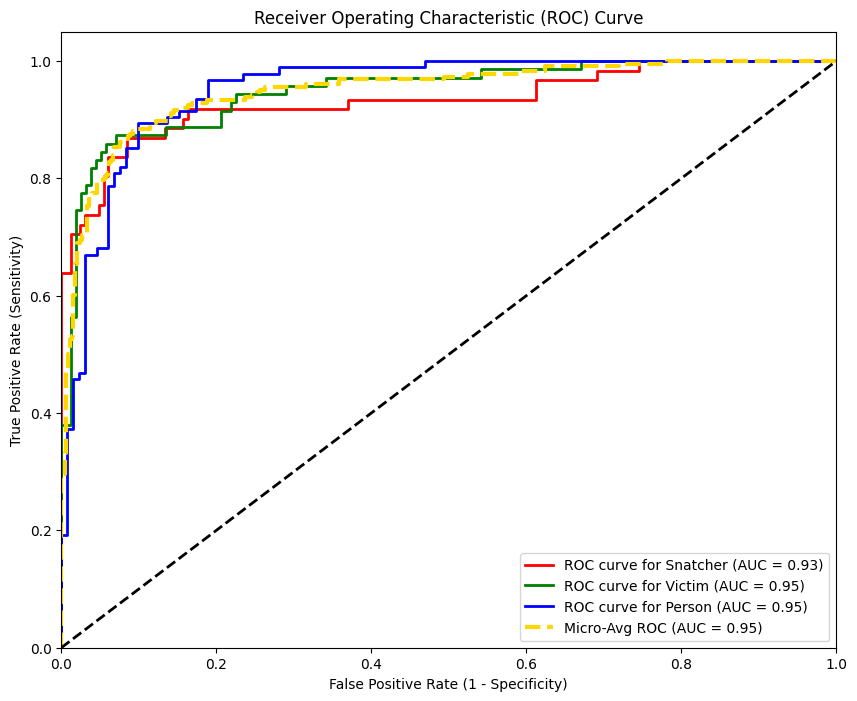

C:\Users\Avijit\AppData\Local\Temp\ipykernel_20584\2870796727.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')


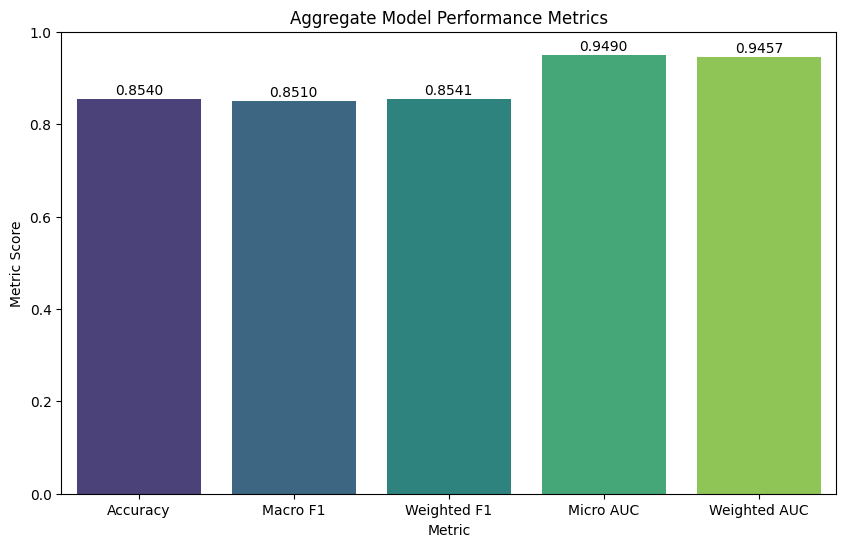

In [3]:
import os, random, time
from glob import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report,
    roc_curve, auc, roc_auc_score
)
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pandas as pd
from sklearn.preprocessing import label_binarize

# === 1. Essential Setup ===
MODEL_PATH = "D:\\I3D\\SRC\\aug_data_i3d.pt"
DATA_ROOT = "D:\\I3D"
VAL_SPLIT = "TESTDATA"
num_classes = 3
classes = ["Snatcher", "Victim", "Person"] 
BATCH_SIZE = 2 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-define the Dataset class used during training
class PtClipDataset(Dataset):
    CLASS_MAP = {"snatcher": 0, "victim": 1, "person": 2}
    def __init__(self, root, split="TRAINDATA"): 
        self.samples = []
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path):
            sys.stdout.write(f"Error: Split directory not found at {split_path}\n"); return
        for folder_name, class_index in self.CLASS_MAP.items():
            folder = os.path.join(split_path, folder_name)
            if os.path.isdir(folder):
                for f in glob(os.path.join(folder, "*.pt")):
                    self.samples.append((f, class_index))
        random.shuffle(self.samples)
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        clip = torch.load(path, map_location='cpu').float()
        return clip, label

# === 2. Model Loading and Weight Transfer ===
sys.stdout.write("Loading base I3D model architecture...\n")
try:
    model = torch.hub.load("facebookresearch/pytorchvideo", "i3d_r50", pretrained=True)
    model.blocks[6].proj = nn.Linear(model.blocks[6].proj.in_features, num_classes)
    model.load_state_dict(torch.load(MODEL_PATH))
    model = model.to(device)
    model.eval()
    sys.stdout.write(f"Successfully loaded model and weights.\n")
except Exception as e:
    sys.stdout.write(f"Error loading model: {e}. Please check internet/file path.\n")
    sys.exit()

# === 3. Data Loading ===
val_ds = PtClipDataset(DATA_ROOT, split=VAL_SPLIT)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

sys.stdout.write(f"Starting evaluation on {len(val_ds)} validation samples...\n")
sys.stdout.flush()

# === 4. Evaluation Loop ===
all_probs_tensor = [] 
all_preds, all_labels = [], []
start_time = time.time()

with torch.no_grad():
    for clips, labels in tqdm(val_loader, desc="Evaluation"):
        clips, labels = clips.to(device), labels.to(device)
        outputs = model(clips)
        probs = torch.softmax(outputs, dim=1)
        
        all_probs_tensor.append(probs.cpu())
        all_labels += labels.cpu().tolist()
        all_preds += outputs.argmax(dim=1).cpu().tolist()

# Convert data for sklearn
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs_np = torch.cat(all_probs_tensor).numpy()
elapsed_time = time.time() - start_time

# === 5. Metrics and Reporting (ENHANCED VISUALIZATION) ===

# --- AGGREGATE METRICS CALCULATION ---
overall_accuracy = accuracy_score(all_labels, all_preds)
macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)
weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
roc_auc_micro = roc_auc_score(all_labels, all_probs_np, average='micro', multi_class='ovr')
roc_auc_weighted = roc_auc_score(all_labels, all_probs_np, average='weighted', multi_class='ovr')


# --- Print Aggregate Metrics ---
sys.stdout.write("\n=== FINAL MODEL PERFORMANCE ANALYSIS ===\n")
sys.stdout.write(f"Total Evaluation Time: {elapsed_time:.2f}s\n")
sys.stdout.write(f"Total Samples: {len(all_labels)}\n")
sys.stdout.write("\n--- AGGREGATE METRICS ---\n")
sys.stdout.write(f"Overall Accuracy:   {overall_accuracy:.4f}\n")
sys.stdout.write(f"Macro Avg Precision: {macro_p:.4f} | Recall: {macro_r:.4f} | F1: {macro_f1:.4f}\n")
sys.stdout.write(f"Weighted Avg P:      {weighted_p:.4f} | Recall: {weighted_r:.4f} | F1: {weighted_f1:.4f}\n")
sys.stdout.write(f"Micro-Avg ROC AUC:   {roc_auc_micro:.4f}\n")
sys.stdout.write(f"Weighted-Avg ROC AUC: {roc_auc_weighted:.4f}\n")

# 1. Classification Report (TEXT METRICS)
sys.stdout.write("\n--- Classification Report (Per-Class Metrics) ---\n")
report = classification_report(all_labels, all_preds, target_names=classes, zero_division=0)
sys.stdout.write(report + "\n")

# 2. Confusion Matrix (VISUALIZATION 1)
cm = confusion_matrix(all_labels, all_preds)
sys.stdout.write("\n--- Confusion Matrix Data ---\n")
sys.stdout.write(str(cm) + "\n")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Model vs. Ground Truth)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# 3. Multi-Class ROC Curve (VISUALIZATION 2: Discriminatory Power)
y_true_bin = label_binarize(all_labels, classes=range(num_classes))

plt.figure(figsize=(10, 8))
colors = ['red', 'green', 'blue']
lw = 2
mean_fpr = np.linspace(0, 1, 100)

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs_np[:, i])
    roc_auc = auc(fpr, tpr)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i], lw=lw,
             label=f'ROC curve for {classes[i]} (AUC = {roc_auc:.2f})')

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), all_probs_np.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

plt.plot(fpr_micro, tpr_micro, color='gold', lw=lw + 1, linestyle='--',
         label=f'Micro-Avg ROC (AUC = {auc_micro:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 4. Bar Plot of Aggregate Metrics (VISUALIZATION 3: Overall Summary)
metrics_data = {
    'Metric': ['Accuracy', 'Macro F1', 'Weighted F1', 'Micro AUC', 'Weighted AUC'],
    'Score': [overall_accuracy, macro_f1, weighted_f1, roc_auc_micro, roc_auc_weighted]
}
metrics_df = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')
plt.ylim(0, 1.0)
for index, row in metrics_df.iterrows():
    plt.text(index, row.Score + 0.01, f'{row.Score:.4f}', color='black', ha="center")
plt.title('Aggregate Model Performance Metrics')
plt.ylabel('Metric Score')
plt.show()

sys.stdout.flush()


=== Final Evaluation ===


Final Eval: 100%|██████████| 32/32 [02:05<00:00,  3.92s/it]
d:\I3D\env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\I3D\env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\I3D\env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



--- Final Classification Report ---
              precision    recall  f1-score   support

    Snatcher       0.00      0.00      0.00        33
      Victim       0.35      1.00      0.51        44
      Person       0.00      0.00      0.00        50

    accuracy                           0.35       127
   macro avg       0.12      0.33      0.17       127
weighted avg       0.12      0.35      0.18       127



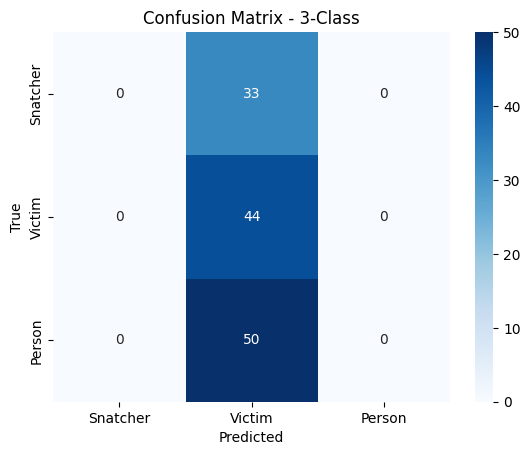

In [4]:

# === 6. Confusion Matrix + Thresholding (MODIFIED for 3 classes) ===
print("\n=== Final Evaluation ===") # Thresholding is typically complex for multi-class, removing specific 0.7 threshold logic
model.eval()
all_probs, all_preds, all_labels = [], [], []
with torch.no_grad():
    for clips, labels in tqdm(val_loader, desc="Final Eval"):
        clips, labels = clips.to(device), labels.to(device)
        outputs = model(clips)
        probs = torch.softmax(outputs, dim=1)
        all_probs += probs.cpu().tolist()
        all_labels += labels.cpu().tolist()

# Apply threshold tuning is generally skipped for 3+ classes, using default argmax
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Default argmax predictions for 3 classes
default_preds = np.argmax(all_probs, axis=1)

print("\n--- Final Classification Report ---")
print(classification_report(all_labels, default_preds, target_names=classes))
cm = confusion_matrix(all_labels, default_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - 3-Class")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [6]:
from sklearn.metrics import accuracy_score
accuracy_score(all_labels, default_preds)*100


34.645669291338585